# Synchrotron small scale log pol tens model

## Imports and data

In [151]:
import os
os.environ["OMP_NUM_THREADS"] = "64"

from pathlib import Path
import wget

import numpy as np
import healpy as hp
from scipy.optimize import curve_fit

import pymaster as nmt
import pysm3.units as u

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["xtick.direction"] = "inout"
mpl.rcParams["ytick.direction"] = "inout"

In [170]:
DATA_DIR = Path(os.path.expandvars("$SCRATCH")) / "pysm" / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)

MAPS = {
    'PolMask': "COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits",
    'IntMask': "COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits",
    'KBand': "wmap_band_iqumap_r9_9yr_K_v5.fits",
    'Haslam': "haslam408_dsds_Remazeilles2014.fits",
    "GalNoApo": "HFI_Mask_GalPlane-apo0_2048_R2.00.fits",
    "GalApo": "HFI_Mask_GalPlane-apo2_2048_R2.00.fits",
}

def VerifyData():
    """ If data not already downloaded, get it from the URLs listed.
    """
    for tag in ["IntMask", "PolMask"]:
        fname = MAPS[tag]
        url = f"https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/{fname}"
        target = DATA_DIR / fname
        if not target.exists():
            wget.download(str(url), str(target))

    for tag in ["KBand"]:
        fname = MAPS[tag]
        url =  f"https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/raw/{fname}"
        target = DATA_DIR / fname
        if not target.exists():
            wget.download(str(url), str(target))

    for tag in ["Haslam"]:
        fname = MAPS[tag]
        url =  f"https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/{fname}"
        target = DATA_DIR / fname
        if not target.exists():
            wget.download(str(url), str(target))

    for tag in ["GalNoApo", "GalApo"]:
        fname = MAPS[tag]
        url = f"http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID={fname}"
        target = DATA_DIR / fname
        if not target.exists():
            wget.download(str(url), str(target))

VerifyData()

NSIDE = 512

DATA = {
    "PolMask": hp.read_map(str(DATA_DIR / MAPS["PolMask"])),
    "IntMask": hp.read_map(str(DATA_DIR / MAPS["IntMask"])),
    "Gal20NoApo": np.round(hp.ud_grade(hp.read_map(str(DATA_DIR / MAPS["GalNoApo"]), field=4), nside_out=NSIDE)),
    "Gal20Apo": hp.ud_grade(hp.read_map(str(DATA_DIR / MAPS["GalApo"]), field=4), nside_out=NSIDE),
    "IntMap": hp.read_map(str(DATA_DIR / MAPS["Haslam"])) * 1e6 * (23. / 0.408) **  -3, # map in K, convert to muK, and scale to 23 GHz
    "PolMap": hp.read_map(str(DATA_DIR / MAPS["KBand"]), field=(1, 2)) * 1e3, # map in mK, convert to muK
}

## Preprocessing and Frolov Transform

Create a joint mask from the intensity and polarization masks. 

Calculate the forward Frolov transform. First we smooth the inputs to the same resolution. 

In [172]:
def FrolovTransformForward(IQU):
    """ From Stokes to polarization tensor
    """
    P = np.sqrt(IQU[1] ** 2 + IQU[2] ** 2)
    log_ratio = np.log((IQU[0] + P) / (IQU[0] - P))
    forward = np.zeros_like(IQU)
    forward[0] = 0.5 * np.log(IQU[0] ** 2 - P ** 2)
    forward[1:] = 0.5 * IQU[1:] * log_ratio / P
    return forward

def FrolovTransformBackward(iqu):
    """ From polarization tensor to Stokes
    """
    backward = np.zeros_like(iqu)
    ei = np.exp(iqu[0])
    p = np.sqrt(iqu[1] ** 2 + iqu[2] ** 2)
    backward[0] = ei * np.cosh(p)
    backward[1:] = iqu[1:] / p * ei * np.sinh(p)
    return backward

NSIDE = 512
DATA["JointMask"] = np.logical_and(hp.ud_grade(DATA["IntMask"], nside_out=NSIDE), hp.ud_grade(DATA["PolMask"], nside_out=NSIDE))

FWHM_SMOOTHING = 2. # in degrees
# 0.88 degrees Kband res
# 56 arcmin beam size haslam
# Do smoothing and rescale pixels where polarized intensity exceeds intensity.
IQU = hp.smoothing(np.concatenate((DATA["IntMap"][None, :], DATA["PolMap"])), fwhm=np.radians(FWHM_SMOOTHING))
P = np.sqrt(IQU[1] ** 2 + IQU[2] ** 2)
idx = np.where(P > IQU[0])[0]
rescaling = np.sqrt(0.99 * IQU[0] ** 2 / P ** 2)
IQU[1:, idx] *= rescaling[None, idx]
DATA["IQU"] = IQU
DATA["iqu"] = FrolovTransformForward(DATA["IQU"])

## Plots Stokes and transformed maps

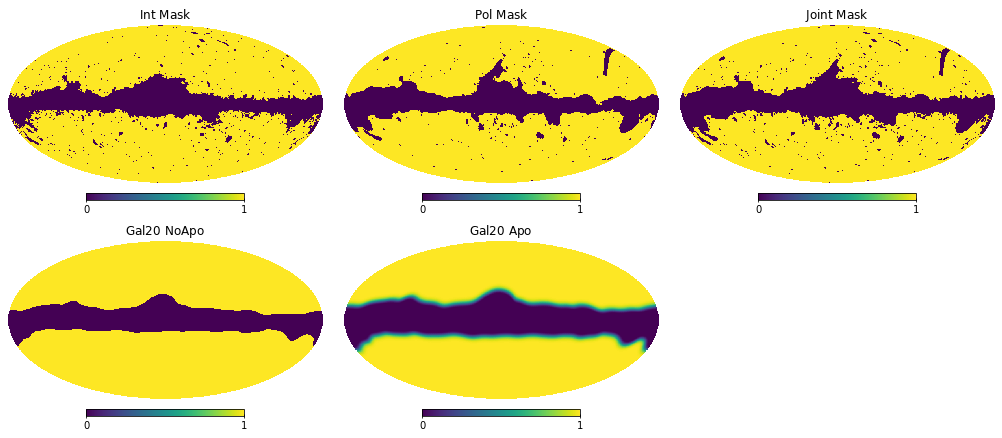

In [173]:
def InspectGNILCMasks():
    fig = plt.figure(figsize=(14, 6))
    hp.mollview(DATA["IntMask"], title=r"${\rm Int~Mask}$", fig=fig, sub=231)
    hp.mollview(DATA["PolMask"], title=r"${\rm Pol~Mask}$", fig=fig, sub=232)
    hp.mollview(DATA["JointMask"], title=r"${\rm Joint~Mask}$", fig=fig, sub=233)
    hp.mollview(DATA["Gal20NoApo"], title=r"${\rm Gal20~NoApo}$", fig=fig, sub=234)
    hp.mollview(DATA["Gal20Apo"], title=r"${\rm Gal20~Apo}$", fig=fig, sub=235)
    fig.savefig('Masks.pdf', bbox_inches='tight')
    return
InspectGNILCMasks()

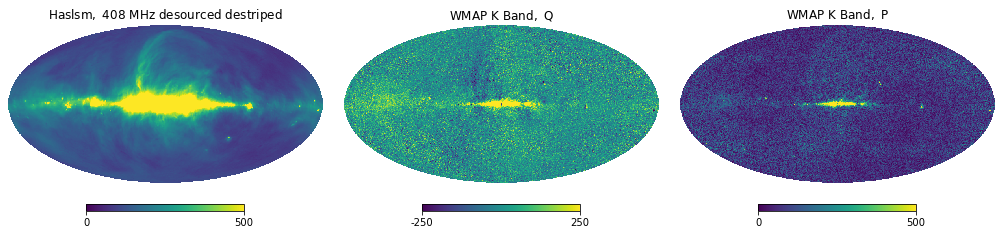

In [5]:
def InspectSyncMaps():
    fig = plt.figure(figsize=(14, 6))
    hp.mollview(DATA["IntMap"], min=0, max=500, title=r"${\rm Haslsm,~408~MHz~desourced~destriped}$", fig=fig, sub=131)
    hp.mollview(DATA["PolMap"][0], min=-250, max=250, title=r"${\rm WMAP~K~Band,~Q}$", fig=fig, sub=132)
    hp.mollview(np.sqrt(DATA["PolMap"][0] ** 2 + DATA["PolMap"][1] ** 2), min=0, max=500, title=r"${\rm WMAP~K~Band,~P}$", fig=fig, sub=133)
    fig = plt.gcf()
    fig.savefig("input_maps_haslam_wmap_kband_P.pdf",  bbox_inches='tight')
    return
InspectSyncMaps()

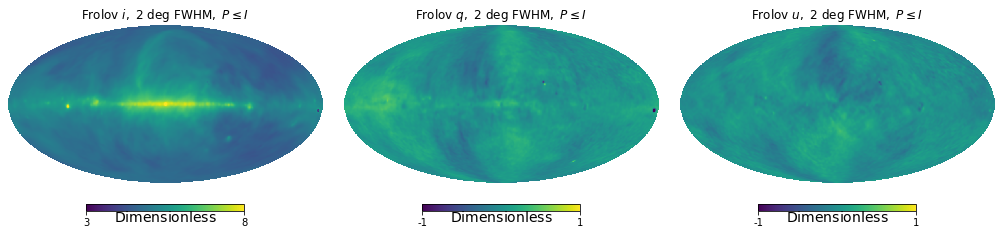

In [6]:
def PlotFrolovTransformediqu():
    fig = plt.figure(figsize=(14, 6))
    kwargs = {"unit": r"${\rm Dimensionless}$", "fig":fig}
    hp.mollview(DATA["iqu"][0], title=r"${\rm Frolov}~i,~2~{\rm deg~FWHM},~P\leq I$", **kwargs, min=3, max=8, sub=131)
    hp.mollview(DATA["iqu"][1], title=r"${\rm Frolov}~q,~2~{\rm deg~FWHM},~P\leq I$", **kwargs, min=-1, max=1, sub=132)
    hp.mollview(DATA["iqu"][2], title=r"${\rm Frolov}~u,~2~{\rm deg~FWHM},~P\leq I$", **kwargs, min=-1, max=1, sub=133)
    fig.savefig("transformed_u_2degfwhm_corrected.pdf")
    return 

PlotFrolovTransformediqu()

## Plot power spectra

In [174]:
def NaMasterI(mask, I, nside, is_Dell=True):
    binning = nmt.NmtBin(nside=nside, nlb=1, is_Dell=is_Dell)
    f0 = nmt.NmtField(mask, I)
    return (binning.get_effective_ells(), nmt.compute_full_master(f0, f0, binning))

def NaMasterQU(mask, QU, nside, is_Dell=True):
    binning = nmt.NmtBin(nside=nside, nlb=1, is_Dell=is_Dell)
    f2 = nmt.NmtField(mask, QU)
    return (binning.get_effective_ells(), nmt.compute_full_master(f2, f2, binning))

def NaMasterIQU(mask, IQU, nside, lmax, is_Dell=True):
    (ells, cl_00) = NaMasterI(mask, IQU[[0]], nside, is_Dell)
    (ells, cl_22) = NaMasterQU(mask, IQU[1:], nside, is_Dell)
    return np.concatenate([ells[None, :], cl_00, cl_22]) # order of axes: ells, tt, ee, eb, be, bb

def CalculatePowerSpectra(keys=["iqu", "IQU"], Dell=[True, False], nside=512):
    """ Calculate the TT, EE, BB, powerspectra of the raw Haslam 408 MHz
    map, and raw WMAP Kband map.

    This requires scaling the Haslam map to 23 GHz for TT comparison with
    polarization. We assume a spatially constant spectral index of -3 for
    this scaling.

    We also multiply the input Haslam map by 1e6 to convert to uK, and we
    multiple the input WMAP Kband by 1e3 to convert from mK to uK.

    The masks are the Planck cosmology intensity and polarization masks.
    """
    for is_Dell in Dell:
        for k in keys:
            spectrum_key = "{}_{}".format(k, "dl" if is_Dell else "cl")
            DATA[spectrum_key] = NaMasterIQU(DATA["Gal20Apo"], DATA[k], nside, is_Dell)
            hp.write_cl(str(DATA_DIR / f"{spectrum_key}.fits"), DATA[spectrum_key], overwrite=True)
    return
CalculatePowerSpectra()

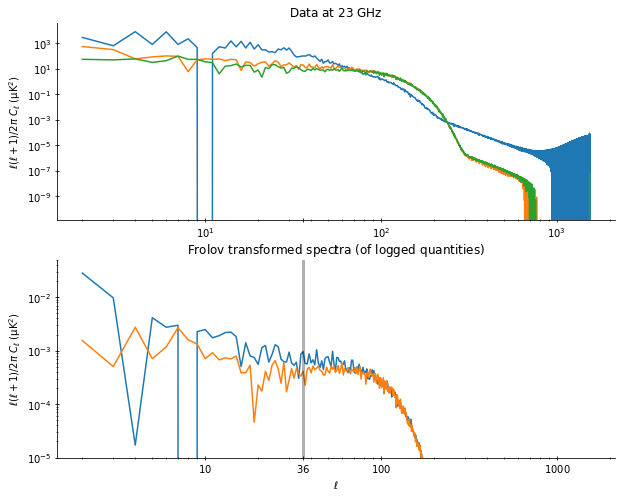

In [175]:
def PlotPowerspectra():
    """ Plot the powerspectra of the Haslam and WMAP Kband maps, scaled
    to 23 GHz, and plotted in uK^2.
    """
    dl = DATA["IQU_dl"]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.loglog(dl[0], dl[1], label=r"${\rm TT,~Haslam}$")    
    ax1.loglog(dl[0], dl[2], label=r"${\rm EE,~K~band}$")
    ax1.loglog(dl[0], dl[5], label=r"${\rm BB,~K~band}$")
    ax1.set_xticks([10, 36, 100, 1000])
    ax1.set_xlabel(r"$\ell$")
    ax1.set_ylabel(r"$\ell (\ell + 1) / 2 \pi~C_\ell~({\rm \mu K}^2)$")
    ax1.set_title(r"${\rm Data~at~23~GHz}$")

    dl = DATA["iqu_dl"]
    ax2.loglog(dl[0], dl[2], label=r"${\rm ee}$")
    ax2.loglog(dl[0], dl[5], label=r"${\rm bb}$")
    ax2.set_xlabel(r"$\ell$")
    ax2.set_ylabel(r"$\ell (\ell + 1) / 2 \pi~C_\ell~({\rm \mu K}^2)$")
    ax2.set_ylim(1e-5, 0.05)
    ax2.axvline(x=36, linewidth=3, alpha=0.3, color='k')
    ax2.set_xticks([10, 36, 100, 1000])
    ax2.set_xticklabels([r"$10$", r"$36$", r"$100$", r"$1000$"])
    ax2.set_title(r"${\rm Frolov~transformed~spectra~(of~logged~quantities)}$")
    
    fig.savefig("spectra_tteebb.pdf")
    return

PlotPowerspectra()

## Fit power laws to power spectra

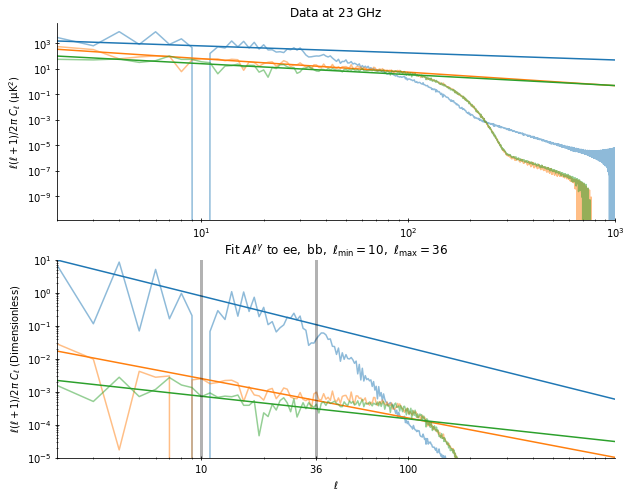

In [176]:
def PowerLaw(ells, amplitude, gamma):
    return amplitude * ells ** gamma

def PerformFitStokes(lmin_fit=10, lmax_fit=36):
    """ Fit power law model to sycnhrotron spectrum over a determined
    range of ells.
    """
    dl = DATA["IQU_dl"]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    for (idx, label) in [(1, r"${\rm TT,~\gamma=}$"), (2, r"${\rm EE,~\gamma=}$"), (5, r"${\rm BB,~\gamma=}$")]:
        pars, cov = curve_fit(PowerLaw, dl[0, lmin_fit-2:lmax_fit-2], dl[idx, lmin_fit-2:lmax_fit-2])
        l1, = ax1.loglog(dl[0], dl[idx], alpha=0.5)
        ax1.loglog(dl[0], PowerLaw(dl[0], *pars), color=l1.get_color(), label=label+f"{pars[1]:.02f}")

    ax1.set_xlim(2, 1000)
    ax1.set_ylabel(r"$\ell (\ell + 1) / 2 \pi~C_\ell~({\rm \mu K}^2)$")
    ax1.set_title(r"${\rm Data~at~23~GHz}$")

    dl = DATA["iqu_dl"]

    for (idx, label) in [(1, r"tt"), (2, r"${\rm ee,~\gamma=}$"), (5, r"${\rm bb,~\gamma=}$")]:
        pars, cov = curve_fit(PowerLaw, dl[0, lmin:lmax], dl[idx, lmin:lmax])
        l1, = ax2.loglog(dl[0], dl[idx], alpha=0.5)
        ax2.loglog(dl[0], PowerLaw(dl[0], *pars), color=l1.get_color(), label=label+r"${:.02f}\pm{:.02f}$".format(pars[1], cov[1, 1]))

    ax2.set_xlabel(r"$\ell$")
    ax2.set_ylabel(r"$\ell (\ell + 1) / 2 \pi~C_\ell~({\rm Dimensionless})$")
    ax2.set_yscale('log')
    ax2.set_ylim(1e-5, 1e1)
    ax2.set_xlim(2, 1000)
    ax2.set_xticks([10, 36, 100])
    ax2.set_xticklabels([r"$10$", r"$36$", r"$100$"])
    ax2.axvline(x=lmin_fit, linewidth=3, alpha=0.3, color='k')
    ax2.axvline(x=lmax_fit, linewidth=3, alpha=0.3, color='k')
    ax2.set_title(r"${\rm Fit~}A\ell^\gamma{\rm~to~ee,~bb},~\ell_{\rm min}=$"+r"${:d},~\ell_{{\rm max}}={:d}$".format(lmin_fit, lmax_fit))
    #fig.savefig("fitted_eebb.pdf")
    return
PerformFitStokes()

In [177]:
def Sigmoid(ell, ell_0, sigma_ell, scale):
    sigmoid = 1. / (1. + np.exp(- scale * (ell - ell_0 - sigma_ell / 2) / sigma_ell))
    return sigmoid, 1 - sigmoid

### Small Scale Realizations

In [179]:
def SmallScaleRealization(mod_fwhm=5, lmin_fit=10, lmax_fit=36, ell_0=36, sigma_ell=0.5, scale=10, nside=512):
    ells = DATA["iqu_dl"][0]
    lmax = len(ells) + 1
    dl = np.zeros((4, lmax + 1))
    cl = np.zeros((4, lmax + 1))
    dlcl = 2 * np.pi / ells / (ells + 1)
    fl, neg_fl = Sigmoid(DATA["iqu_dl"][0], ell_0, sigma_ell, scale)
    for i, j in enumerate([1, 2, 5]):
        pars, cov = curve_fit(PowerLaw, DATA["iqu_dl"][0, lmin_fit-2:lmax_fit-2], DATA["iqu_dl"][j, lmin_fit-2:lmax_fit-2])
        cl[i, :] = np.pad(dlcl * fl * PowerLaw(DATA["iqu_dl"][0], *pars), (2, 0))
        dl[i, :] = np.pad(fl * PowerLaw(DATA["iqu_dl"][0], *pars), (2, 0))
    DATA["iqu_cl_ss"] = cl
    DATA["iqu_dl_ss"] = dl
    DATA["iqu_ss"] = np.array(hp.synfast(cl, nside, new=True))
    return

SmallScaleRealization()

### Polarization Modulation

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 1.02000e+02, 1.83000e+02,
        3.00000e+01, 6.03280e+04, 3.93345e+05, 7.00722e+05, 6.21576e+05,
        4.74436e+05, 3.25745e+05, 1.90738e+05, 1.16917e+05, 7.70220e+04,
        5.29620e+04, 3.66170e+04, 2.95500e+04, 2.05560e+04, 1.49100e+04,
        9.78500e+03, 7.70300e+03, 8.08300e+03, 3.19100e+03, 5.42000e+02,
        3.76000e+02, 2.73000e+02, 3.20000e+01, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7

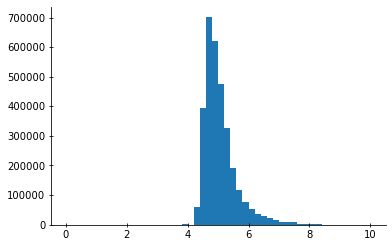

In [269]:
plt.hist(DATA["iqu"][0], bins=50, range=[0, 10])

In [270]:
def MinMaxScaler(arr, x1, x2):
    return x1 + (x2 - x1) * (arr - arr.min()) / (arr.max() - arr.min())

def Modulator():
    i = DATA["iqu"][0]
    in_mask = DATA["Gal20NoApo"].astype(bool)
    out_mask = ~in_mask
    ismo = hp.smoothing(i, fwhm=np.pi/180. * 5)
    modulator = np.zeros_like(ismo)
    mskmd = ismo > 5.5
    modulator[mskmd] = 1.5
    modulator[~mskmd] = MinMaxScaler(ismo[~mskmd], .5, 1.5)
    #modulator[mskmd] = MinMaxScaler(ismo[mskmd], 1.1, 2)
    #modulator[in_mask] = MinMaxScaler(modulator[in_mask], norm_min, norm_max)
    #modulator = hp.smoothing(modulator, fwhm=np.radians(fwhm))
    return modulator

def TwoTierModulator():
    i = DATA["iqu"][0]
    in_mask = DATA["Gal20NoApo"].astype(bool)
    out_mask = ~in_mask
    ismo = hp.smoothing(i, fwhm=np.pi/180. * 5)
    modulator = np.zeros_like(ismo)
    mskmd = ismo > 5
    modulator[mskmd] = MinMaxScaler(ismo[mskmd], 1.1, 2)
    modulator[~mskmd] = MinMaxScaler(ismo[~mskmd], .1, 1.1)
    return modulator

#DATA["Modulator_P"] = Modulator()
DATA["Modulator_I"] = TwoTierModulator()

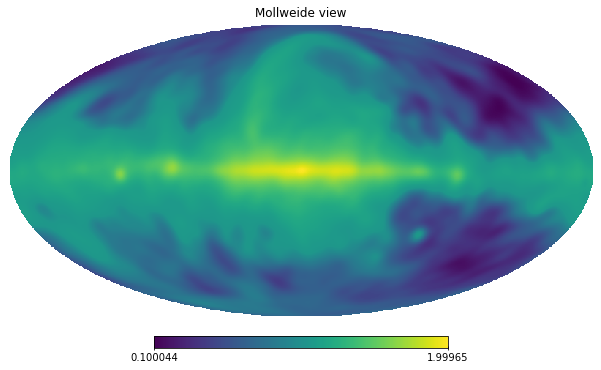

In [271]:
hp.mollview(DATA["Modulator_I"])

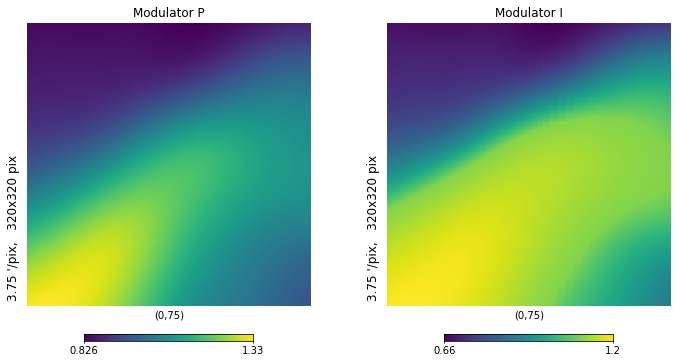

In [272]:
def ModulatorZoomPlot(lat=75):
    kwds = {"reso": 3.75, "xsize": 320, "rot":[0, lat]}
    sub = lambda i: 131 + i
    sub(1)
    fig = plt.figure(figsize=(15, 5))
    hp.gnomview(DATA["Modulator_P"],  title='Modulator P', sub=sub(1), **kwds)
    hp.gnomview(DATA["Modulator_I"],  title='Modulator I', sub=sub(2), **kwds)
    return
ModulatorZoomPlot()

### Large Scale Filtering

In [219]:
def LargeScaleFiltering(ell_0=36, sigma_ell=0.5, scale=10, nside=512):
    (i, q, u) = hp.read_map(str(DATA_DIR / "transformed_iqu_fwhm2deg_corrected.fits"), field=(0, 1, 2))
    fl, neg_fl = Sigmoid(np.arange(2, 3 * nside - 1), ell_0, sigma_ell, scale)
    alms = hp.map2alm((i, q, u))
    alms_ls = np.array([hp.almxfl(alm, np.pad(neg_fl, (2, 0), mode="constant", constant_values=1)) for alm in alms])
    DATA["iqu_ls"] = hp.alm2map(alms_ls, nside)
    return
    
LargeScaleFiltering()

In [273]:
DATA["iqu_rlz"] = DATA["iqu_ls"] + DATA["Modulator_P"][None, :] * DATA["iqu_ss"]
DATA["iqu_rlz"][0] = DATA["iqu_ls"][0] + DATA["Modulator_I"] * DATA["iqu_ss"][0] / 10.

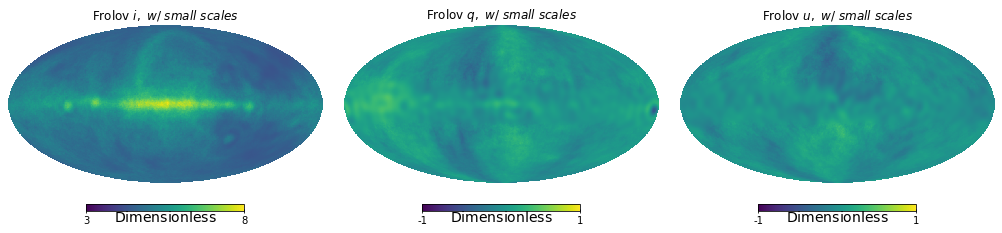

In [274]:
def PlotWithSmallScales():
    fig = plt.figure(figsize=(14, 6))
    kwargs = {"unit": r"${\rm Dimensionless}$", "fig":fig}
    hp.mollview(DATA["iqu_rlz"][0], title=r"${\rm Frolov}~i,~w/~small~scales$", **kwargs, min=3, max=8, sub=131)
    hp.mollview(DATA["iqu_rlz"][1], title=r"${\rm Frolov}~q,~w/~small~scales$", **kwargs, min=-1, max=1, sub=132)
    hp.mollview(DATA["iqu_rlz"][2], title=r"${\rm Frolov}~u,~w/~small~scales$", **kwargs, min=-1, max=1, sub=133)
    return 
PlotWithSmallScales()

### Small Scale Grid Plot

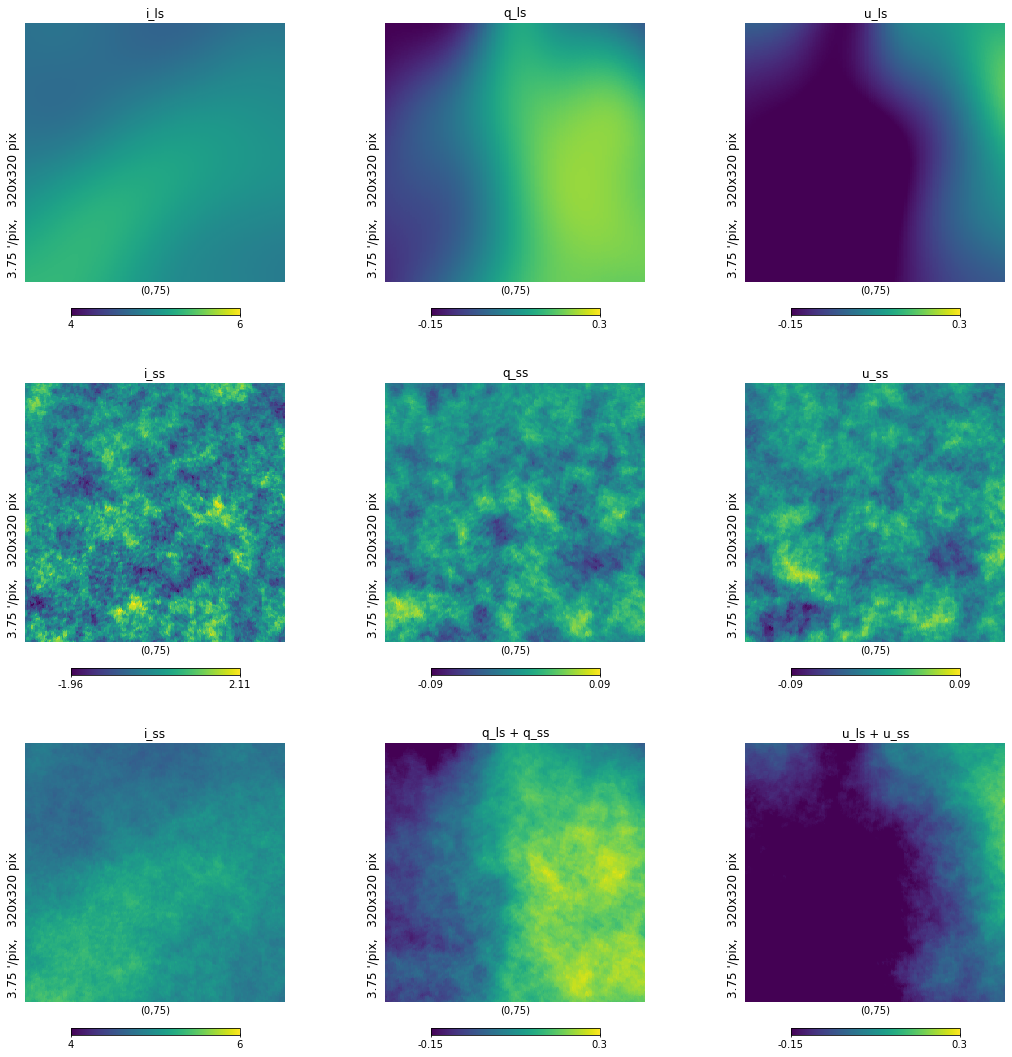

In [275]:
def SmallScalesZoomPlot(lat=75):
    kwds = {"reso": 3.75, "xsize": 320, "rot":[0, lat]}
    sub = lambda i: 331 + i
    sub(1)
    fig = plt.figure(figsize=(15, 15))
    hp.gnomview(DATA["iqu_ls"][0],  title='i_ls', sub=sub(0), **kwds, min=4, max=6)
    hp.gnomview(DATA["iqu_ls"][1],  title='q_ls', sub=sub(1), **kwds, min=-0.15, max=0.3)
    hp.gnomview(DATA["iqu_ls"][2],  title='u_ls', sub=sub(2), **kwds, min=-0.15, max=0.3)
    hp.gnomview(DATA["Modulator_P"] * DATA["iqu_ss"][0],  title='i_ss', sub=sub(3), **kwds)
    hp.gnomview(DATA["Modulator_P"] * DATA["iqu_ss"][1],  title='q_ss', sub=sub(4), **kwds, min=-0.09, max=0.09)
    hp.gnomview(DATA["Modulator_P"] * DATA["iqu_ss"][2],  title='u_ss', sub=sub(5), **kwds, min=-0.09, max=0.09)
    hp.gnomview(DATA["iqu_rlz"][0],  title='i_ss', sub=sub(6), **kwds, min=4, max=6)
    hp.gnomview(DATA["iqu_rlz"][1],  title='q_ls + q_ss', sub=sub(7), **kwds, min=-0.15, max=0.3)
    hp.gnomview(DATA["iqu_rlz"][2],  title='u_ls + u_ss', sub=sub(8), **kwds, min=-0.15, max=0.3)
    return
SmallScalesZoomPlot()

### Small Scale Power Spectra

In [276]:
CalculatePowerSpectra(keys=["iqu_rlz", "iqu_ss"], Dell=[True])

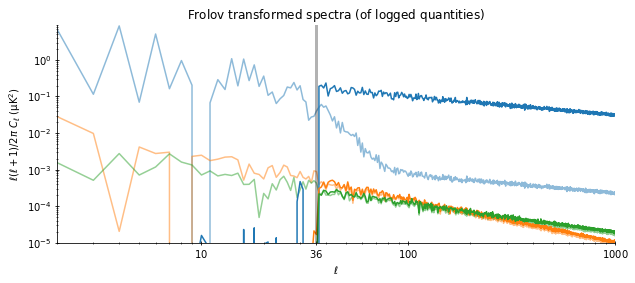

In [277]:
def PlotPowerspectra():
    """ Plot the powerspectra of the Haslam and WMAP Kband maps, scaled
    to 23 GHz, and plotted in uK^2.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    dl = DATA["iqu_rlz_dl"]
    ells = dl[0]
    l1, = ax.semilogx(dl[0], dl[1], alpha=0.5, label=r"${\rm ee}$")
    l2, = ax.semilogx(dl[0], dl[2], alpha=0.5, label=r"${\rm ee}$")
    l3, = ax.semilogx(dl[0], dl[5], alpha=0.5, label=r"${\rm bb}$")
    #dl = DATA["iqu_dl_ss"]
    #ax.semilogx(ells, dl[0][2:], color=l1.get_color(), label=r"${\rm ee}$")
    #ax.semilogx(ells, dl[1][2:], color=l1.get_color(), label=r"${\rm ee}$")
    #ax.semilogx(ells, dl[2][2:], color=l2.get_color(), label=r"${\rm bb}$")
    
    dl = DATA["iqu_ss_dl"]
    ax.semilogx(ells, dl[1], color=l1.get_color(), label=r"${\rm ee}$")
    ax.semilogx(ells, dl[2], color=l2.get_color(), label=r"${\rm ee}$")
    ax.semilogx(ells, dl[5], color=l3.get_color(), label=r"${\rm bb}$")
    ax.set_xlabel(r"$\ell$")
    ax.set_ylabel(r"$\ell (\ell + 1) / 2 \pi~C_\ell~({\rm \mu K}^2)$")
    ax.set_xlim(2, 1000)
    ax.set_ylim(1e-5)
    ax.set_yscale('log')
    ax.axvline(x=36, linewidth=3, alpha=0.3, color='k')
    ax.set_xticks([10, 36, 100, 1000])
    ax.set_xticklabels([r"$10$", r"$36$", r"$100$", r"$1000$"])
    ax.set_title(r"${\rm Frolov~transformed~spectra~(of~logged~quantities)}$")
    
    fig.savefig("spectra_tteebb.pdf")
    return

PlotPowerspectra()

### Intensity Modulation

In [27]:
dl = hp.read_cl(str(DATA_DIR / "frolov_2degfwhm_corr_dl.fits"))
i = hp.read_map(str(DATA_DIR / "transformed_iqu_fwhm2deg_corrected.fits"), field=0)

In [18]:
modulator = hp.smoothing(i, fwhm=np.pi/180. * fwhm)
modulator[out_mask] = np.clip(modulator[out_mask], 0, norm_max)
modulator[in_mask] = minmax_scaler(modulator[in_mask], norm_min, norm_max)
modulator = hp.smoothing(modulator, fwhm=np.radians(fwhm))

In [38]:
nside = 512
cl = np.zeros(len(dl[0]) + 2)
fl, neg_fl = Sigmoid(dl[0], ell_0, sigma_ell, scale)

dlcl = 1. / (dl[0] * (dl[0] + 1) / 2 / np.pi)
pars, cov = curve_fit(PowerLaw, dl[0, lmin:lmax], dl[1, lmin:lmax])
cl = np.pad(dlcl * fl * PowerLaw(dl[0], *pars), (2, 0))

iss = hp.synfast(cl, nside)

In [42]:
dl_iss = NaMaster00(int_mask, iss, nside, is_Dell=True)

NameError: name 'int_mask' is not defined

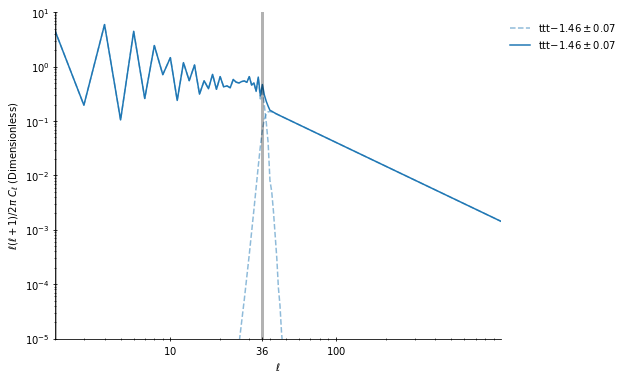

In [32]:
lmin = 2
lmax = 36
ell_0 = 36
sigma_ell = 1
scale = 1
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for (idx, label) in [(1, r"ttt")]:
    pars, cov = curve_fit(PowerLaw, dl[0, lmin:lmax], dl[idx, lmin:lmax])
    fl, neg_fl = Sigmoid(dl[0], ell_0, sigma_ell, scale)

    l1, = ax.loglog(dl[0], neg_fl * dl[idx], alpha=0.5, linestyle="--")
    ax.loglog(dl[0], fl * PowerLaw(dl[0], *pars), color=l1.get_color(), label=label+r"${:.02f}\pm{:.02f}$".format(pars[1], cov[1, 1]), alpha=0.5, linestyle="--")
    ax.loglog(dl[0], fl * PowerLaw(dl[0], *pars) + neg_fl * dl[idx], color=l1.get_color(), label=label+r"${:.02f}\pm{:.02f}$".format(pars[1], cov[1, 1]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\ell (\ell + 1) / 2 \pi~C_\ell~({\rm Dimensionless})$")
ax.set_yscale('log')
ax.set_ylim(1e-5, 1e1)
ax.set_xlim(2, 1000)
ax.set_xticks([10, 36, 100])
ax.set_xticklabels([r"$10$", r"$36$", r"$100$"])
ax.axvline(x=lmin, linewidth=3, alpha=0.3, color='k')
ax.axvline(x=lmax, linewidth=3, alpha=0.3, color='k')
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
ax.tick_params(direction="inout", which="both")

In [26]:
modulator_p = Modulator()

NameError: name 'out_mask' is not defined

In [ ]:
fwhm = 2
norm_min = 0.1
norm_max = 0.8

i = hp.read_map(str(DATA_DIR / "transformed_iqu_fwhm2deg_corrected.fits"), field=0)
    

In [ ]:
modulator = hp.smoothing(i, fwhm=np.pi/180. * fwhm)
modulator[in_mask] = sigmoid(minmax_scaler(modulator[in_mask], norm_min, norm_max), sigma=0.1)
modulator[out_mask] = minmax_scaler(modulator[out_mask], modulator[in_mask].max(), 0.8)
modulator_i = hp.smoothing(modulator, fwhm=np.radians(fwhm))

In [ ]:
norm_min=0.6
norm_max=1.
modulator_i = sigmoid(minmax_scaler(hp.smoothing(i, fwhm=np.pi/180. * fwhm), norm_min, norm_max), sigma=0.08)

plt.hist(modulator_i, bins=50);

In [ ]:
hp.mollview(modulator_i)
hp.mollview(i_ls + modulator_i * iss)

In [ ]:
int_mask = hp.read_map(str(DATA_DIR / MAPS["IntMask"]))
pol_mask = hp.read_map(str(DATA_DIR / MAPS["PolMask"]))
int_map = hp.read_map(str(DATA_DIR / MAPS["Haslam"])) * 1e6 # map in K, convert to muK
int_map *= (23. / 0.408) **  -3 # scale to 23 GHz
pol_map = hp.read_map(str(DATA_DIR / MAPS["KBand"]), field=(1, 2)) * 1e3 # map in mK, convert to muK

int_mask = hp.ud_grade(int_mask, nside_out=nside)
pol_mask = hp.ud_grade(pol_mask, nside_out=nside)

lmax=1000
# combine int and pol masks. This will be necessary as
# frolov transform mixes stokes parameters, requiring common
# analysis region.
joint_mask = np.logical_and(int_mask, pol_mask)

for is_Dell in [True]:
    binning = nmt.NmtBin(nside=nside, nlb=5, lmax=lmax, is_Dell=is_Dell)
    f2 = nmt.NmtField(joint_mask, [q_ls + modulator_p * qss, u_ls + modulator_p * uss])
    f0 = nmt.NmtField(joint_mask, [i_ls])

    cl_22 = nmt.compute_full_master(f2, f2, binning)
    cl_00 = nmt.compute_full_master(f0, f0, binning)

    cl = np.concatenate([binning.get_effective_ells()[None, :], cl_00, cl_22])
    if is_Dell:
        fname = "modulated_rlz_dl.fits"
    else:
        fname = "modulated_rlz_cl.fits"
    hp.write_cl(str(DATA_DIR / fname), cl, overwrite=True)

In [ ]:
dl_data = hp.read_cl(str(DATA_DIR / "frolov_2degfwhm_corr_dl.fits"))
dl_rlz = hp.read_cl(str(DATA_DIR / "modulated_rlz_dl.fits"))

fig, ax = plt.subplots(1, 1)
for (idx, label) in [(1, r"{\rm tt}"), (2, r"${\rm ee}$"), (5, r"${\rm bb}$")]:
    l1, = ax.loglog(dl_data[0], dl_data[idx], alpha=0.5, linestyle="-")
    ax.loglog(dl_rlz[0], dl_rlz[idx], linestyle="-", color=l1.get_color())
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\ell (\ell + 1) / 2 \pi~C_\ell~({\rm Dimensionless})$")
ax.set_yscale('log')
ax.set_ylim(1e-5, 1e1)
ax.set_xlim(2, 1000)
ax.set_xticks([10, 36, 100])
ax.set_xticklabels([r"$10$", r"$36$", r"$100$"])
ax.axvline(x=lmin, linewidth=3, alpha=0.3, color='k')
ax.axvline(x=36, linewidth=3, alpha=0.3, color='k')
ax.legend(frameon=False, loc=3)
ax.tick_params(direction="inout", which="both")
#ax.set_title(r"${\rm Splice~large~scales~with~}A\ell^\gamma{\rm~to~ee,~bb},~\ell_{\rm min}=$"+r"${:d},~\ell_{{\rm max}}={:d}$".format(lmin, lmax))

In [ ]:
rlz_IQU = FrolovTransformBackward(np.array([i_ls + modulator_i * iss, q_ls + modulator_p * qss, u_ls + modulator_p * uss]))

In [ ]:
I = hp.read_map(str(DATA_DIR / MAPS["Haslam"])) * 1e6 * (23. / 0.408) ** -3
(Q, U) = hp.read_map(str(DATA_DIR / MAPS["KBand"]), field=(1, 2)) * 1e3

(Ismo, Qsmo, Usmo) = hp.smoothing((I, Q, U), fwhm=np.radians(2))

In [ ]:
lat = 75
kwds = {"reso": 3.75, "xsize": 320, "rot":[0, lat]}

sub = lambda i: 331 + i
sub(1)

fig = plt.figure(figsize=(15, 15))

hp.gnomview(I,  title='I Haslam', sub=sub(0), **kwds)
hp.gnomview(Q,  title='Q Kband', sub=sub(1), **kwds)
hp.gnomview(U,  title='U Kband', sub=sub(2), **kwds)
hp.gnomview(Ismo,  title='Q Haslam 2deg smo', sub=sub(3), **kwds)
hp.gnomview(Qsmo,  title='Q Kband 2deg smo', sub=sub(4), **kwds)
hp.gnomview(Usmo,  title='U Kband 2deg smo', sub=sub(5), **kwds)
hp.gnomview(rlz_IQU[0],  title='I sim', sub=sub(6), **kwds)
hp.gnomview(rlz_IQU[1],  title='Q sim', sub=sub(7), **kwds)
hp.gnomview(rlz_IQU[2],  title='U sim', sub=sub(8), **kwds)

In [ ]:
int_mask = hp.read_map(str(DATA_DIR / MAPS["IntMask"]))
pol_mask = hp.read_map(str(DATA_DIR / MAPS["PolMask"]))
int_map = hp.read_map(str(DATA_DIR / MAPS["Haslam"])) * 1e6 # map in K, convert to muK
int_map *= (23. / 0.408) **  -3 # scale to 23 GHz
pol_map = hp.read_map(str(DATA_DIR / MAPS["KBand"]), field=(1, 2)) * 1e3 # map in mK, convert to muK

int_mask = hp.ud_grade(int_mask, nside_out=nside)
pol_mask = hp.ud_grade(pol_mask, nside_out=nside)

lmax=1000
# combine int and pol masks. This will be necessary as
# frolov transform mixes stokes parameters, requiring common
# analysis region.
joint_mask = np.logical_and(int_mask, pol_mask)

for is_Dell in [True]:
    binning = nmt.NmtBin(nside=nside, nlb=5, lmax=lmax, is_Dell=is_Dell)
    f2 = nmt.NmtField(joint_mask, [rlz_IQU[1], rlz_IQU[2]])
    f0 = nmt.NmtField(joint_mask, [rlz_IQU[0]])

    cl_22 = nmt.compute_full_master(f2, f2, binning)
    cl_00 = nmt.compute_full_master(f0, f0, binning)

    cl = np.concatenate([binning.get_effective_ells()[None, :], cl_00, cl_22])
    if is_Dell:
        fname = "stokes_modulated_rlz_dl.fits"
    else:
        fname = "stokes_modulated_rlz_cl.fits"
    hp.write_cl(str(DATA_DIR / fname), cl, overwrite=True)

In [ ]:
dl_data = hp.read_cl(str(DATA_DIR / "haslam_kband_spectra_dl.fits"))
dl_rlz = hp.read_cl(str(DATA_DIR / "stokes_modulated_rlz_dl.fits"))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for (idx, label) in [(1, r"${\rm TT}$"), (2, r"${\rm EE}$"), (5, r"${\rm BB}$")]:
    pars, cov = curve_fit(PowerLaw, dl[0, lmin:lmax], dl[idx, lmin:lmax])
    l1, = ax.loglog(dl_data[0], dl_data[idx], alpha=0.5)
    ax.loglog(dl_rlz[0], dl_rlz[idx], color=l1.get_color(), label=label)
    #ax.loglog(dl[0], PowerLaw(dl[0], *pars), color=l1.get_color(), label=label+f"{pars[1]:.02f}")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\ell (\ell + 1) / 2 \pi~C_\ell~({\rm \mu K}^2)$")
ax.legend(frameon=False)
ax.tick_params(direction="inout", which="both")
ax.set_title(r"${\rm Data~(faint)~and~sim~(solid)~at~23~GHz,~using~joint~mask}$")

In [ ]:
(check_i, check_q, check_u) = hp.read_map(str(DATA_DIR / "transformed_iqu_fwhm2deg_corrected.fits"), field=(0, 1, 2))
(check_I, check_Q, check_U) = FrolovTransformBackward(np.array([check_i, check_u, check_u]))

In [ ]:
lat = 75
kwds = {"reso": 3.75, "xsize": 320, "rot":[0, lat]}

sub = lambda i: 331 + i
sub(1)

fig = plt.figure(figsize=(15, 15))

hp.gnomview(I,  title='I Haslam', sub=sub(0), **kwds)
hp.gnomview(Q,  title='Q Kband', sub=sub(1), **kwds)
hp.gnomview(U,  title='U Kband', sub=sub(2), **kwds)
hp.gnomview(check_I,  title='Q Forward / backward', sub=sub(3), **kwds)
hp.gnomview(check_Q,  title='Q Forward / backward', sub=sub(4), **kwds)
hp.gnomview(check_U,  title='U Forward / backward', sub=sub(5), **kwds)
hp.gnomview(rlz_IQU[0],  title='I sim', sub=sub(6), **kwds)
hp.gnomview(rlz_IQU[1],  title='Q sim', sub=sub(7), **kwds)
hp.gnomview(rlz_IQU[2],  title='U sim', sub=sub(8), **kwds)

In [ ]:
lat = 75
kwds = {"reso": 3.75, "xsize": 320, "rot":[0, lat]}

sub = lambda i: 331 + i
sub(1)

fig = plt.figure(figsize=(15, 15))

hp.gnomview(I,  title='I Haslam', sub=sub(0), **kwds)
hp.gnomview(Q,  title='Q Kband', sub=sub(1), **kwds)
hp.gnomview(U,  title='U Kband', sub=sub(2), **kwds)
hp.gnomview(check_i,  title='i', sub=sub(3), **kwds)
hp.gnomview(check_q,  title='q', sub=sub(4), **kwds)
hp.gnomview(check_i,  title='u', sub=sub(5), **kwds)
hp.gnomview(i_ls,  title='i_ls', sub=sub(6), **kwds)
hp.gnomview(q_ls + modulator * qss,  title='q sim', sub=sub(7), **kwds)
hp.gnomview(u_ls + modulator * uss,  title='u sim', sub=sub(8), **kwds)

In [ ]:
(i, q, u) = hp.read_map(str(DATA_DIR / "transformed_iqu_fwhm2deg_corrected.fits"), field=(0, 1, 2))
fl, neg_fl = Sigmoid(np.arange(2, 3 * nside - 1), ell_0, sigma_ell, scale)
alms = hp.map2alm((i, q, u))
alms_ls = np.array([hp.almxfl(alm, np.pad(neg_fl, (2, 0), mode='constant', constant_values=1)) for alm in alms])
(i_ls, q_ls, u_ls) = hp.alm2map(alms_ls, nside)
    

In [ ]:
(i_ss, q_ss, u_ss) = hp.alm2map(np.array([hp.almxfl(alm, np.pad(fl, (2, 0))) for alm in alms]), nside)

In [ ]:
lat = 75
kwds = {"reso": 3.75, "xsize": 320, "rot":[0, lat]}

sub = lambda i: 331 + i
sub(1)

fig = plt.figure(figsize=(15, 15))

hp.gnomview(i,  title='I Haslam', sub=sub(0), **kwds)
hp.gnomview(q,  title='Q Kband', sub=sub(1), **kwds)
hp.gnomview(u,  title='U Kband', sub=sub(2), **kwds)
hp.gnomview(i_ls,  title='I Haslam', sub=sub(3), **kwds)
hp.gnomview(q_ls,  title='Q Kband', sub=sub(4), **kwds)
hp.gnomview(u_ls,  title='U Kband', sub=sub(5), **kwds)
hp.gnomview(i_ss,  title='I Haslam', sub=sub(6), **kwds)
hp.gnomview(q_ss,  title='Q Kband', sub=sub(7), **kwds)
hp.gnomview(u_ss,  title='U Kband', sub=sub(8), **kwds)

In [ ]:
ilm = hp.map2alm(i)

In [ ]:
reconi = hp.alm2map(ilm, nside)

In [ ]:
lat = 75
kwds = {"reso": 3.75, "xsize": 320, "rot":[0, lat]}

sub = lambda i: 321 + i
sub(1)

fig = plt.figure(figsize=(15, 15))

hp.gnomview(i,  title='I Haslam', sub=sub(0), **kwds)
hp.gnomview(reconi,  title='Q Kband', sub=sub(1), **kwds)
hp.gnomview(hp.alm2map(hp.almxfl(ilm, np.pad(fl, (2, 0))), nside),  title='Q Kband', sub=sub(2), **kwds)
hp.gnomview(hp.alm2map(hp.almxfl(ilm, np.pad(neg_fl, (2, 0), mode="constant", constant_values=1)), nside),  title='Q Kband', sub=sub(3), **kwds)
hp.gnomview(hp.alm2map(hp.almxfl(ilm, np.pad(fl, (2, 0)) + np.pad(neg_fl, (2, 0))), nside),  title='Q Kband', sub=sub(4), **kwds)
hp.gnomview(hp.alm2map(hp.almxfl(ilm, np.ones_like(fl)), nside),  title='Q Kband', sub=sub(5), **kwds)

In [ ]:
plt.plot(fl)
plt.plot(neg_fl)

In [ ]:
fl + neg_fl

In [ ]:
(fl + neg_fl).shape

In [ ]:
np.ones_like(fl)

In [ ]:
np.ones_like(fl).shape

In [ ]:
(fl + neg_fl == np.ones_like(fl)).all()